# 1b_Preprocessing_RAG

This notebook prepares datasets for use in our **RAG** pipeline. It focuses on enriching the training and PubMed datasets with unique identifiers and source metadata to support reliable retrieval, traceability, and evaluation throughout the RAG workflow.

---

## Contents

The utility classes used in this notebook are defined in `utils/preprocessing_RAG.py`.

### Topic 1: Preprocessing Training Set for RAG Upsert
- 1 Load the preprocessed training dataset from `data/raw/train_dataset.json` 
- 2 Get stats & check original source dataset distribution for future retrieval process
- 3 Add unique, type-specific `id` fields to each question
- 4 Special processing for **Multiple Choice** questions 
    - 4.1 raw char as correct answer --> full string correct answer
         ![MC_char correct answer](visuals/images/RAG_preprocessing/MC_char.png)
         
    - 4.2 correct answers like **"All of the above."** / **"None of the above."** need to display the list of correct strings in the answer field 
        ![MC all / none correct answer](visuals/images/RAG_preprocessing/MC_all_none.png)
- 5 Save the processed dataset in a format suitable for vector store upsertion in Pinecone

---

### Topic 2: Preprocessing PubMed Abstracts
- 1 combine parts to a full 2.2 mio PubMed abstracts file
- 2 Add a pubmed `id` to each item
- 3 clean & format randomly sampled 250k  for Topic Modeling and later integration into the vector store (adding "clean_content" field)
- 4 save preprocessed PubMed dataset





---
### Topic 1:  Preprocessing Training Set for RAG Upsert
---

In [1]:
import sys
from pathlib import Path
import json
import pprint
from tqdm import tqdm
import random, spacy
%matplotlib inline

from utils.preprocessing_RAG import DataPaths, DataStats, AddingIDs

sys.path.append(str(Path("clin_IQ/").resolve()))

/Users/lorenaraichle/Developer/NLP-project_v1/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/lorenaraichle/Developer/NLP-project_v1/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Stats for 'train_raw':
 - true_false: 169015 examples
 - multiple_choice: 173861 examples
 - short_answer: 54060 examples
 - multi_hop: 15763 examples
Total entries: 412699

 Source Distribution:

- true_false:
  TF2-qiaojin/PubMedQA: 169015
All items in 'true_false' have a 'source' field.


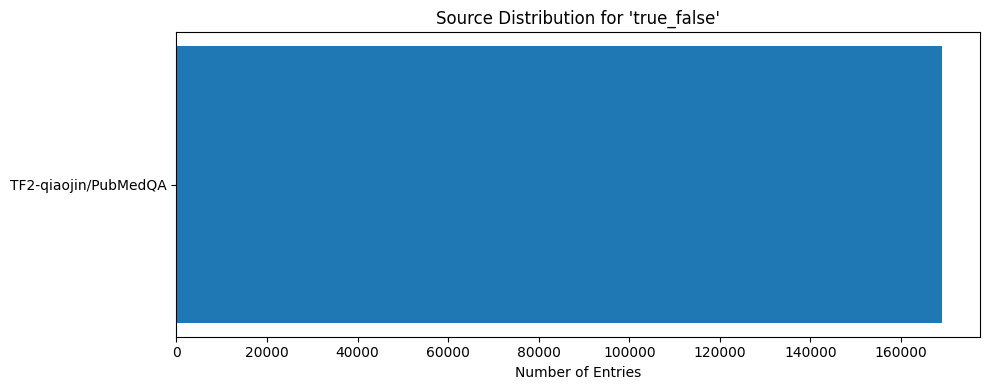


- multiple_choice:
  MC3-openlifescienceai/medmcqa: 149618
  MC4-UCSC-VLAA/MedReason: 12058
  MC1-bigbio/med_qa: 10149
  MC2-stellalisy/mediQ: 2036
All items in 'multiple_choice' have a 'source' field.


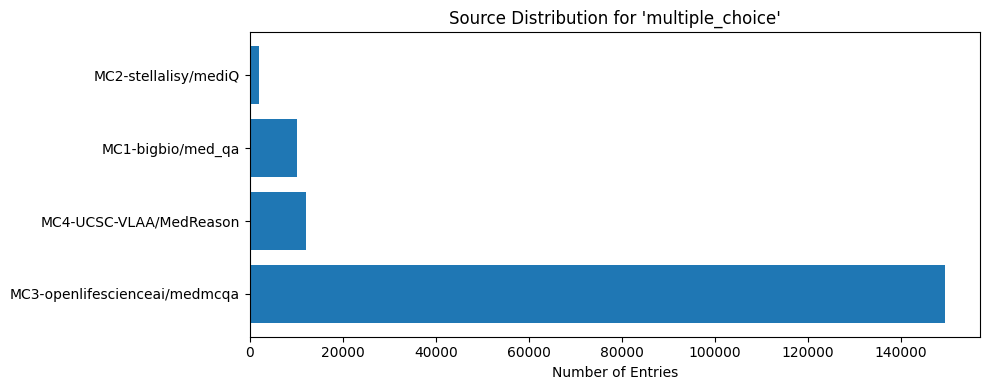


- short_answer:
  SA2-Ajayaadhi/Medical-QA: 39841
  SA3-thedevastator/comprehensive-medical-q-a-dataset: 13198
  SA1-HPAI-BSC/OpenMedQA: 1021
All items in 'short_answer' have a 'source' field.


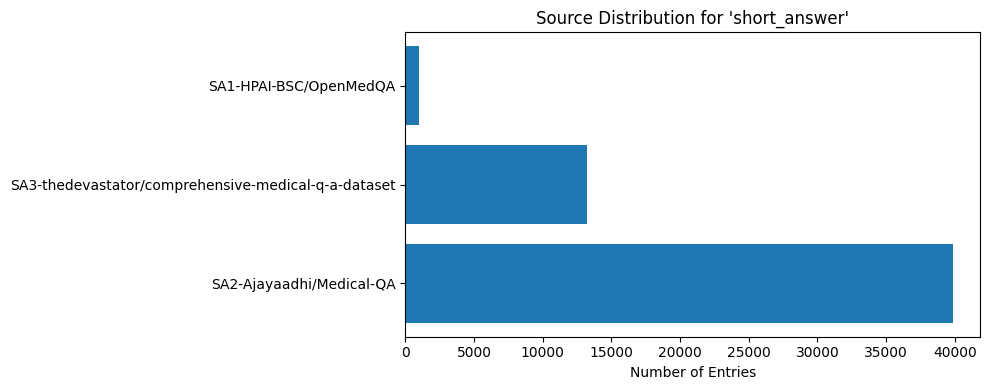


- multi_hop:
  MH-FreedomIntelligence/medical-o1-reasoning-SFT: 15763
All items in 'multi_hop' have a 'source' field.


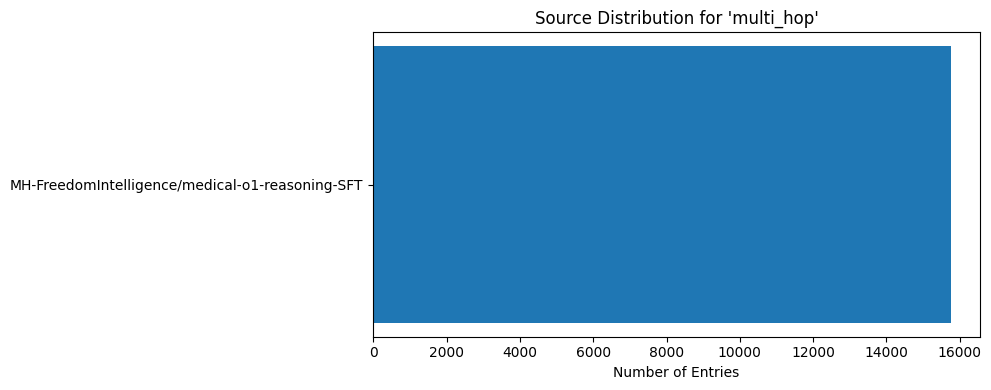

In [2]:


# note: source fields were added in 1a_Preprocessing_dataset

# 1 loading raw training dataset consisting of combined huggingface datasets for all question types
data = DataPaths.load("train_raw")

#2 enable source checking for each question type
stats = DataStats.get_stats("train_raw", show_sources=True)


In [3]:
# 3 adding id fields including counter and question type to every training set item
data_with_ids = AddingIDs.add_ids_traindata(data)

#check first id for each question type
for qtype, questions in data_with_ids.items():
    print(f"\ First item in '{qtype}':")
    if questions:
        print(json.dumps(questions[0], indent=2))
    else:
        print("  (No entries found)")
        


\ First item in 'true_false':
{
  "answer": "True",
  "question": "Is reduced Klotho associated with the presence and severity of coronary artery disease?",
  "source": "TF2-qiaojin/PubMedQA",
  "type": "true_false",
  "id": "tf_0"
}
\ First item in 'multiple_choice':
{
  "correct_answer": "B",
  "options": {
    "A": "1-1 \u00bd year after eruption",
    "B": "2-3 year after eruption",
    "C": "6 months after eruption",
    "D": "None of the above"
  },
  "question": "Root completion of permanent tooth occurs",
  "source": "MC3-openlifescienceai/medmcqa",
  "type": "multiple_choice",
  "id": "mc_0"
}
\ First item in 'short_answer':
{
  "question": "What is the family classification of California encephalitis?",
  "answer": "California encephalitis belongs to the Bunyaviridae family. This family of viruses is known to cause a variety of diseases in humans and animals, including fever, encephalitis, and hemorrhagic fever. California encephalitis is caused by the California encephalitis

In [4]:
# 4 preprocessing for Multiple Choice "None of the above" etc. answers

#all of the above example (char)
pprint.pprint(data_with_ids["multiple_choice"][508])

print("---")

# None of the above example (char)
pprint.pprint(data_with_ids["multiple_choice"][798])


{'correct_answer': 'D',
 'id': 'mc_508',
 'options': {'A': 'Opioids',
             'B': 'Verapamil',
             'C': 'Lignocaine',
             'D': 'All of the above'},
 'question': 'Drug with elimination by lsl order kinetics -',
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice'}
---
{'correct_answer': 'D',
 'id': 'mc_798',
 'options': {'A': 'Anterior interventricular aery',
             'B': 'Posterior interventricular aery',
             'C': 'Circumflex aery',
             'D': 'None of the above'},
 'question': 'Cardiac dominance is based on ?',
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice'}


In [5]:

def is_all_answer(option: str) -> bool:
    return option and 'all' in option.lower()

def is_none_answer(option: str) -> bool:
    return option and 'none' in option.lower()

repl_all_mask = [
    1 if is_all_answer(entry['options'][entry['correct_answer']]) else 0
    for entry in data_with_ids['multiple_choice']
]

repl_none_mask = [
    1 if is_none_answer(entry['options'][entry['correct_answer']]) else 0
    for entry in data_with_ids['multiple_choice']
]

for idx, entry in enumerate(data['multiple_choice']):
    correct_option = entry['options'][entry['correct_answer']]

    if repl_all_mask[idx]:
        entry['correct_answer'] = ', '.join([
            opt for key, opt in entry['options'].items()
            if opt and opt.strip() != ""
        ])
    elif repl_none_mask[idx]:
        entry['correct_answer'] = ''
    else:
        entry['correct_answer'] = correct_option


#all of the above exmaple -> full list of correct strings
pprint.pprint(data_with_ids["multiple_choice"][508])

print("---")

# None of the above exmaple -> " "
pprint.pprint(data_with_ids["multiple_choice"][798])



{'correct_answer': 'Opioids, Verapamil, Lignocaine, All of the above',
 'id': 'mc_508',
 'options': {'A': 'Opioids',
             'B': 'Verapamil',
             'C': 'Lignocaine',
             'D': 'All of the above'},
 'question': 'Drug with elimination by lsl order kinetics -',
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice'}
---
{'correct_answer': '',
 'id': 'mc_798',
 'options': {'A': 'Anterior interventricular aery',
             'B': 'Posterior interventricular aery',
             'C': 'Circumflex aery',
             'D': 'None of the above'},
 'question': 'Cardiac dominance is based on ?',
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice'}


In [6]:
# 5 Save processed RAG training set 
DataPaths.save("train_processed", data_with_ids)

--- 
### Topic 2: Preprocessing PubMed Abstracts
---



In [13]:
# 1 combine to a full Pubmed file for further preprocessing
pubmed_1 = []
with open(DataPaths.paths["pubmed_part1"], "r", encoding="utf-8") as f:
    for line in f:
        try:
            pubmed_1.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Skipped malformed line in part 1: {e}")


pubmed_2 = []
with open(DataPaths.paths["pubmed_part2"], "r", encoding="utf-8") as f:
    for line in f:
        try:
            pubmed_2.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Skipped malformed line in part 2: {e}")

combined_pubmed = pubmed_1 + pubmed_2
print(f"Total Combined Entries: {len(combined_pubmed)}")


print("\n Example entry:")
pprint(combined_pubmed[0])



Skipped malformed line in part 1: Unterminated string starting at: line 1 column 167 (char 166)
Skipped malformed line in part 2: Unterminated string starting at: line 1 column 212 (char 211)
Total Combined Entries: 1227493

 Example entry:
{'PMID': 21,
 'content': '(--)-alpha-Bisabolol has a primary antipeptic action depending on '
            'dosage, which is not caused by an alteration of the pH-value. The '
            'proteolytic activity of pepsin is reduced by 50 percent through '
            'addition of bisabolol in the ratio of 1/0.5. The antipeptic '
            'action of bisabolol only occurs in case of direct contact. In '
            'case of a previous contact with the substrate, the inhibiting '
            'effect is lost.',
 'contents': '[Biochemical studies on camomile components/III. In vitro '
             'studies about the antipeptic activity of (--)-alpha-bisabolol '
             "(author's transl)]. (--)-alpha-Bisabolol has a primary "
             'antipept

In [15]:
# Save combined pubmed dataset
DataPaths.save("pubmed_raw", combined_pubmed)

In [8]:
# 2 add pubmed ids 
pubmed = DataPaths.load("pubmed_raw")

stats = DataStats.get_stats("pubmed_raw", show_sources=False)




Stats for 'pubmed_raw':
Total entries: 2209839
Sample keys: ['id', 'title', 'content', 'contents', 'PMID']
Entries missing 'id': 0


In [9]:

pubmed_with_ids = AddingIDs.add_ids_pubmed(pubmed)
pprint.pprint(pubmed_with_ids[0])


{'PMID': 21,
 'content': '(--)-alpha-Bisabolol has a primary antipeptic action depending on '
            'dosage, which is not caused by an alteration of the pH-value. The '
            'proteolytic activity of pepsin is reduced by 50 percent through '
            'addition of bisabolol in the ratio of 1/0.5. The antipeptic '
            'action of bisabolol only occurs in case of direct contact. In '
            'case of a previous contact with the substrate, the inhibiting '
            'effect is lost.',
 'contents': '[Biochemical studies on camomile components/III. In vitro '
             'studies about the antipeptic activity of (--)-alpha-bisabolol '
             "(author's transl)]. (--)-alpha-Bisabolol has a primary "
             'antipeptic action depending on dosage, which is not caused by an '
             'alteration of the pH-value. The proteolytic activity of pepsin '
             'is reduced by 50 percent through addition of bisabolol in the '
             'ratio of 1/

In [10]:
pubmed = DataPaths.save("pubmed_processed_all", pubmed_with_ids)

In [ ]:
# 3. preprocessing with spacy for topic modeling, adding "clean_content" field in file
# adding cleaned items to each entry
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])
stop_words = nlp.Defaults.stop_words

def clean_doc(sp):
    return " ".join(
        t.lemma_ for t in sp
        if not t.is_punct
           and not t.is_space
           and t.lemma_ not in stop_words
           and len(t) > 2
    )

random.seed(42)
sampled = random.sample(pubmed_with_ids, 250000)

texts = ((item["title"] + " " + item["content"]).lower() for item in sampled)
for item, doc in tqdm(zip(sampled, nlp.pipe(texts,
                                            batch_size=1000,
                                            n_process=4)),
                      total=len(sampled),
                      desc="Cleaning"):
    item["clean_content"] = clean_doc(doc)



# 4. save to final pubmed json file
pubmed_clean250k = DataPaths.save("pubmed_preprocessed_250k", sampled)

# check final saved dataset sizes after and before processing

In [11]:
pubmed = DataPaths.load("pubmed_preprocessed_250k")
stats = DataStats.get_stats("pubmed_preprocessed_250k", show_sources=False)


Stats for 'pubmed_preprocessed_250k':
Total entries: 250000
Sample keys: ['id', 'title', 'content', 'contents', 'PMID', 'clean_content']
Entries missing 'id': 0


In [12]:
pubmed = DataPaths.load("pubmed_processed_all")
stats = DataStats.get_stats("pubmed_processed_all", show_sources=False)


Stats for 'pubmed_processed_all':
Total entries: 2209839
Sample keys: ['id', 'title', 'content', 'contents', 'PMID']
Entries missing 'id': 0


In [13]:
data = DataPaths.load("train_processed")

stats = DataStats.get_stats("train_processed", show_sources=False)


Stats for 'train_processed':
 - true_false: 169015 examples
 - multiple_choice: 173861 examples
 - short_answer: 54060 examples
 - multi_hop: 15763 examples
Total entries: 412699


In [14]:
data = DataPaths.load("train_raw")
stats = DataStats.get_stats("train_raw", show_sources=False)


Stats for 'train_raw':
 - true_false: 169015 examples
 - multiple_choice: 173861 examples
 - short_answer: 54060 examples
 - multi_hop: 15763 examples
Total entries: 412699
